# Deploying a XGBoost model
- badges: true
- comments: true
- categories: [xgboost]

In [69]:
import pandas as pd
import numpy as np
import xgboost as xgb
import re
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
np.random.seed(42)

##  Load data and build a model

In [45]:
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

In [46]:
X_y_train = xgb.DMatrix(data=X_train[["pclass", "age", "fare", "sibsp", "parch"]], label=y_train.astype(int))
X_test = xgb.DMatrix(data=X_test[["pclass", "age", "fare", "sibsp", "parch"]])

In [49]:
X_train[["pclass", "age", "fare", "sibsp", "parch"]].head()

,pclass,age,fare,sibsp,parch
662,3.0,40.0,7.2250,0.0,0.0
164,1.0,35.0,26.5500,0.0,0.0
871,3.0,NaN,7.7500,0.0,0.0
1298,3.0,36.0,9.5000,0.0,0.0
1004,3.0,NaN,7.7875,0.0,0.0


In [52]:
params = {
    "base_score": np.mean(y_train.astype(int)),
    "eta":  0.1,
    "max_depth": 3,
    "gamma": 3,
    "objective": "reg:squarederror",
    "eval_metric": "mae"
}
model = xgb.train(
    params=params, 
    dtrain=X_y_train, 
    num_boost_round=3
)

## Visualization of model

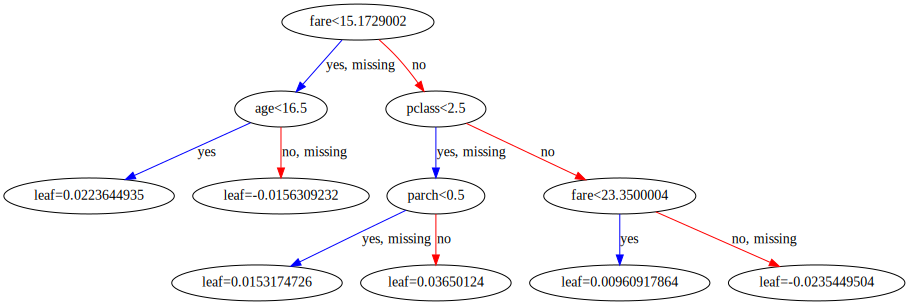

In [53]:
xgb.to_graphviz(booster = model, num_trees=0)

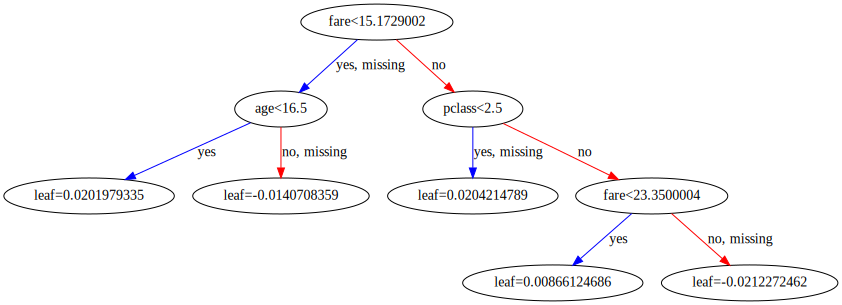

In [54]:
xgb.to_graphviz(booster = model, num_trees=1)

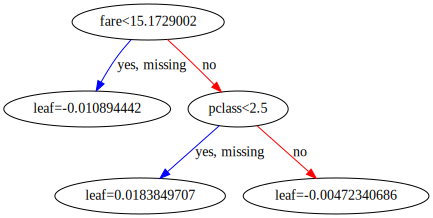

In [55]:
xgb.to_graphviz(booster = model, num_trees=2)

In [59]:
print("\n".join(model.get_dump()))

0:[fare<15.1729002] yes=1,no=2,missing=1
	1:[age<16.5] yes=3,no=4,missing=4
		3:leaf=0.0223644935
		4:leaf=-0.0156309232
	2:[pclass<2.5] yes=5,no=6,missing=5
		5:[parch<0.5] yes=11,no=12,missing=11
			11:leaf=0.0153174726
			12:leaf=0.03650124
		6:[fare<23.3500004] yes=13,no=14,missing=14
			13:leaf=0.00960917864
			14:leaf=-0.0235449504

0:[fare<15.1729002] yes=1,no=2,missing=1
	1:[age<16.5] yes=3,no=4,missing=4
		3:leaf=0.0201979335
		4:leaf=-0.0140708359
	2:[pclass<2.5] yes=5,no=6,missing=5
		5:leaf=0.0204214789
		6:[fare<23.3500004] yes=13,no=14,missing=14
			13:leaf=0.00866124686
			14:leaf=-0.0212272462

0:[fare<15.1729002] yes=1,no=2,missing=1
	1:leaf=-0.010894442
	2:[pclass<2.5] yes=5,no=6,missing=5
		5:leaf=0.0183849707
		6:leaf=-0.00472340686



## Convert dump string to a .py file 

In [63]:
def string_parser(s):
    if len(re.findall(r":leaf=", s)) == 0:
        out  = re.findall(r"[\w.-]+", s)
        tabs = re.findall(r"[\t]+", s)
        if (out[4] == out[8]):
            missing_value_handling = (" or np.isnan(x['" + out[1] + "']) ")
        else:
            missing_value_handling = ""
            
        if len(tabs) > 0:
            return (re.findall(r"[\t]+", s)[0].replace('\t', '    ') + 
                    '        if state == ' + out[0] + ':\n' +
                    re.findall(r"[\t]+", s)[0].replace('\t', '    ') +
                    '            state = (' + out[4] +  
                    ' if ' +  "x['" + out[1] +"']<" + out[2] + missing_value_handling + 
                    ' else ' + out[6] + ')\n' )
        
        else:
            return ('        if state == ' + out[0] + ':\n' +
                    '            state = (' + out[4] +  
                    ' if ' +  "x['" + out[1] +"']<" + out[2] + missing_value_handling +
                    ' else ' + out[6] + ')\n' )
    else:
        out = re.findall(r"[\d.-]+", s)
        return (re.findall(r"[\t]+", s)[0].replace('\t', '    ') + 
                '        if state == ' + out[0] + ':\n    ' +
                re.findall(r"[\t]+", s)[0].replace('\t', '    ') + 
                '        return ' + out[1] + '\n')
        
def tree_parser(tree, i):
    if i == 0:
        return ('    if num_booster == 0:\n        state = 0\n'
             + "".join([string_parser(tree.split('\n')[i]) for i in range(len(tree.split('\n'))-1)]))
    else:
        return ('    elif num_booster == '+str(i)+':\n        state = 0\n'
             + "".join([string_parser(tree.split('\n')[i]) for i in range(len(tree.split('\n'))-1)])) 
    
def model_to_py(base_score, model, out_file):
    trees = model.get_dump()
    result = ["import numpy as np\n\n" 
             +"def xgb_tree(x, num_booster):\n"]
    
    for i in range(len(trees)):
        result.append(tree_parser(trees[i], i))
    
    with open(out_file, 'w') as the_file:
        the_file.write("".join(result) + "\ndef xgb_predict(x):\n    predict = " + str(base_score) + "\n"
                 + "# initialize prediction with base score\n" 
                 + "    for i in range(" 
                 + str(len(trees))  
                 + "):\n        predict = predict + xgb_tree(x, i)"
                 + "\n    return predict")

model_to_py(params['base_score'], model, 'xgb_model.py')

## Prediction using dump file

In [74]:
import xgb_model

passenger_data_1 = {'pclass':3, 'age':np.nan, 'sibsp':0, 'parch':0, 'fare':7.8958}
passenger_data_2 = {'pclass':1, 'age':46, 'sibsp':0, 'parch':0, 'fare':26}

print(xgb_model.xgb_predict(passenger_data_1))
print(xgb_model.xgb_predict(passenger_data_2))

0.34144773395253103
0.43616785725253104
